#Лабораторная работа №3

In [ ]:
import numpy as np
from random import random
import math
import os
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt
from random import uniform as uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, accuracy_score
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Функция чтения датасета из colab
def ReadDataSet():
  y_key = [0, 1]
  x_set, y_set = [], []
  path = "/content/drive/My Drive/neural networks/lab2/"
  directory_name = ["wristwatch", "wallclock"]
  first_directory = path + directory_name[0]
  second_directory = path + directory_name[1]
  pathes = [first_directory, second_directory]

  size = (16, 16)
  for i in range(len(pathes)):
    files = listdir(pathes[i])
    for j in files:
      image = Image.open(pathes[i] + '/' + j)
      image = image.resize(size).convert('L')
      image = np.asarray(image) / 255
      x_set.append(image)
      y_set.append(y_key[i])
  return x_set, y_set

In [ ]:
#Функция для выводы картинок на экран
def outPutDataset(x_dataset, y_dataset):
  plt.figure(figsize = (26 , 6))
  for i in range(len(x_dataset)):
    plt.subplot(2 , 10 , i + 1)
    plt.title("Class: {0}".format(y_dataset[i]))
    plt.imshow(x_dataset[i], cmap = "gray")

In [ ]:
x_dataset, y_dataset = ReadDataSet()

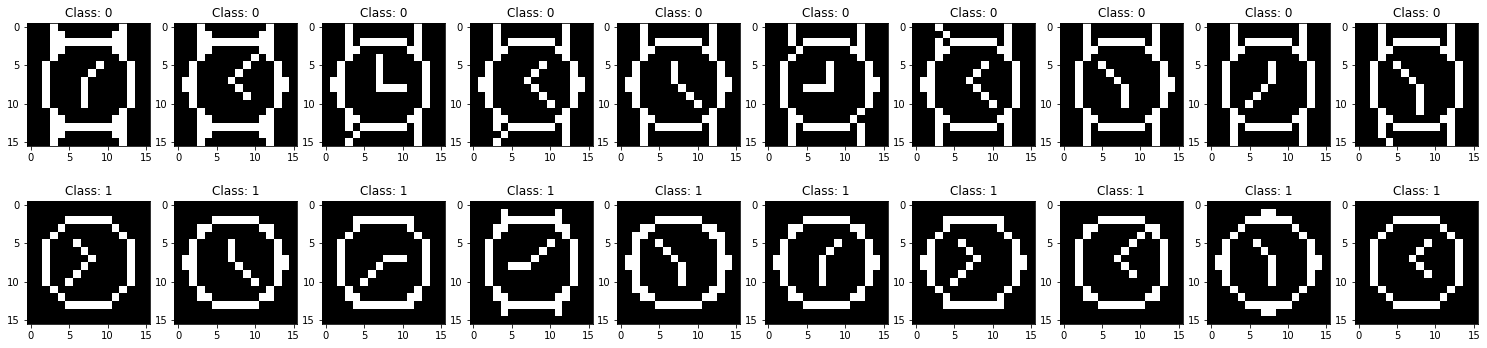

In [ ]:
outPutDataset(x_dataset, y_dataset)

In [ ]:
def mini_batch(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, stratify=y)
  
  print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
  print(f"Количество строк в y_test по классам: {np.bincount(y_test)}") 
  return x_train, y_train, x_test, y_test

In [ ]:
def get_reshaped(arr):
  for i in range(len(arr)):
    arr[i] = arr[i].reshape([-1])
    arr[i] = np.append(arr[i], 1)
  return arr

In [ ]:
x_dataset = get_reshaped(x_dataset)

In [ ]:
x_train, y_train, x_test, y_test = mini_batch(x_dataset, y_dataset)

print(y_train)
print(y_test)

Количество строк в y_train по классам: [8 8]
Количество строк в y_test по классам: [2 2]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
[1, 0, 1, 0]


In [ ]:
x_train = np.array(x_train, np.float32)
x_test = np.array(x_test, np.float32)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(type(x_train))

<class 'numpy.ndarray'>


In [ ]:
y_train = np.array(y_train, np.float32)
y_test = np.array(y_test, np.float32)

print(y_train)

[1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.]


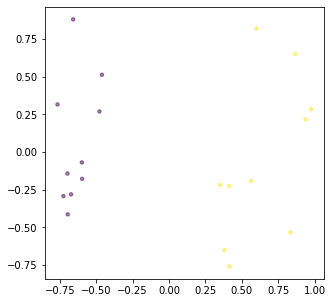

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_reduce = pca.fit_transform(x_dataset)

pca_x1 = pca_reduce[:, 0]
pca_x2 = pca_reduce[:, 1]

plt.figure(figsize=(5, 5))
plt.scatter(pca_x1 , pca_x2, s = 12 , c = y_dataset , alpha = 0.5)

In [ ]:
from sklearn.svm import SVC , LinearSVC
from sklearn.metrics import accuracy_score , confusion_matrix

In [ ]:
svm = SVC(kernel = 'linear' , C = 10)
svm.fit(x_train, y_train)

y_predict = svm.predict(x_test)

linear_acc = accuracy_score(y_true = y_test , y_pred = y_predict)
print(linear_acc)

1.0


In [ ]:
class SVM:
  def __init__(self, kernel = 'linear', C = 10, epochs = 1000, degree = 3, gamma = 1):
    self.kernel = {
        'linear' : lambda x, y : np.dot(x, y.T),
        'poly' : lambda x, y : np.dot(x, y.T) ** degree,
        #'rbf' : lambda x, y : np.exp(-gamma * np.sum((y - x[:, np.newaxis]) ** 2), axis = 1)
    }[kernel]

    self.C = C
    self.epochs = epochs
    
  def lim_t(self, t, v0, u):
    # допущение -- считаем движение по одной из осей
    t = (np.clip(v0 + t * u, 0, self.C) - v0)[1] / u[1]
    return (np.clip(v0 + t * u, 0, self.C) - v0)[0] / u[0]
    
  def fit(self, X, y):
    self.X = X.copy()
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype= float)
    self.K = self.kernel(self.X, self.X) * self.y[:, np.newaxis] * self.y

    for epoch in range(self.epochs):
      if epoch % 10 == 0:
        print(f'epoch {epoch}')
      for indxM in range(len(self.lambdas)):
        # должны считать все L, но пожалуй не стоит
        indxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[indxM, indxL], [indxL, indxM]],
                   [[indxM, indxL], [indxM, indxL]]]
        v0 = self.lambdas[[indxM, indxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[indxM, indxL]], axis = 1)
        u = np.array([-self.y[indxL], self.y[indxM]])
        # чзх сделал нехорошое дело чтобы не делить на ноль
        t_ = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[indxM, indxL]] = v0 + u * self.lim_t(t_, v0, u)
      indx = np.nonzero(self.lambdas > 1E-15)
      self.b = np.mean((1.0 - np.sum(self.K[indx] * self.lambdas, axis = 1))
                        * self.y[indx])

  def predict_(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis = 1) + self.b
    
  def predict(self, X):
    return (np.sign(self.predict_(X)) + 1) // 2


In [ ]:
def rename(y_value):
  print(type(y_value))
  return y_value.astype(np.float32, copy=False)


In [ ]:
y_train = rename(y_train)
y_test = rename(y_test)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
[1. 0. 1. 0.]
[1. 0. 1. 0.]
accuracy = 1.0


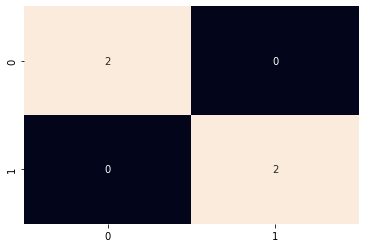

In [ ]:
manual_SVM = SVM(kernel='linear', C = 10, epochs = 50)

manual_SVM.fit(x_train, y_train)

y_pred_m = manual_SVM.predict(x_test)
print(y_pred_m)
print(y_test)

linear_acc_m = accuracy_score(y_true = y_test, y_pred = y_pred_m)
linear_conf_m = confusion_matrix(y_test, y_pred_m)

print(f'accuracy = {linear_acc_m}')
sns.heatmap(linear_conf_m.T, annot = True, cbar = False, fmt = 'd')

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
[1. 0. 1. 0.]
[1. 0. 1. 0.]
accuracy = 1.0


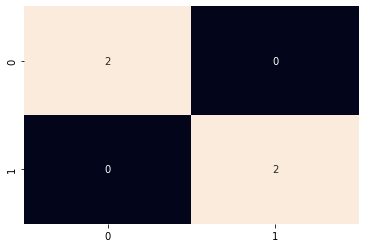

In [ ]:
manual_SVM = SVM(kernel='poly', C = 10, epochs = 50)

manual_SVM.fit(x_train, y_train)

y_pred_m = manual_SVM.predict(x_test)
print(y_pred_m)
print(y_test)

linear_acc_m = accuracy_score(y_true = y_test, y_pred = y_pred_m)
linear_conf_m = confusion_matrix(y_test, y_pred_m)

print(f'accuracy = {linear_acc_m}')
sns.heatmap(linear_conf_m.T, annot = True, cbar = False, fmt = 'd')